In [1]:
from weavepy import *

use_aliases = True

In [2]:
# Parameters
## Climate
climate_variable = "2m_temperature"
climate_variable_comparison = '<=' # '<', '<=', '>', or '>='
climate_variable_threshold = 5 # Number in units of variable
## Energy 
energy_variable = "solar_generation_capacity_factor"
energy_variable_comparison = '<' # '<', '<=', '>', or '>='
energy_variable_threshold = 0.05 # Number in units of variable
##Geography
country = "FR"

In [3]:
# Load data
climate = {}
period = "historical"
climate[period] = get_data(variable=climate_variable, period=period, verbose = False)[country]
period = "future"
for model in ["cmcc_cm2_sr5", "mpi_esm1_2_hr", "ec_earth3"]:
    climate[model] = get_data(variable=climate_variable, period=period, model = model, verbose = False)[country]

In [4]:
# Load data
energy = {}
period = "historical"
energy[period] = get_data(variable=energy_variable, period=period, verbose = False)[country]
period = "future"
for model in ["cmcc_cm2_sr5", "mpi_esm1_2_hr", "ec_earth3"]:
    energy[model] = get_data(variable=energy_variable, period=period, model = model, verbose = False)[country]

In [5]:
assert climate.keys() == energy.keys()
names = list(climate.keys())

In [6]:
# Apply aliases
if use_aliases :
    for a in names: 
        climate[model_aliases[a]] = climate.pop(a)
        energy[model_aliases[a]] = energy.pop(a)
    names = list(climate.keys())

In [7]:
# Aggregate
climate_daily = {}
for a in names:
    climate_daily[a] = climate[a].groupby(climate[a].index.floor('d')).mean()
energy_daily = {}
for a in names:
    energy_daily[a] = energy[a].groupby(energy[a].index.floor('d')).mean()

In [8]:
# Identify problematic events
climate_days, energy_days, compound_days = {}, {}, {}
for a in names:
    climate_days[a] = identify_events(climate_daily[a], climate_variable_comparison, climate_variable_threshold)
    energy_days[a] = identify_events(energy_daily[a], energy_variable_comparison, energy_variable_threshold)
    compound_days[a] = climate_days[a] & energy_days[a]

In [9]:
# Identify events
climate_events, energy_events, compound_events = {}, {}, {}
for a in names:
    climate_events[a] = find_events(climate_days[a])
    energy_events[a] = find_events(energy_days[a])
    compound_events[a] = find_events(compound_days[a])

In [10]:
# period length
period_len = {}
for a in names:
    period_len[a] = len(np.unique(climate[a].index.year))

# period min/max
period_min_max = {}
for a in names:
    period_min_max[a] = (climate[a].index.year.min(), climate[a].index.year.max())

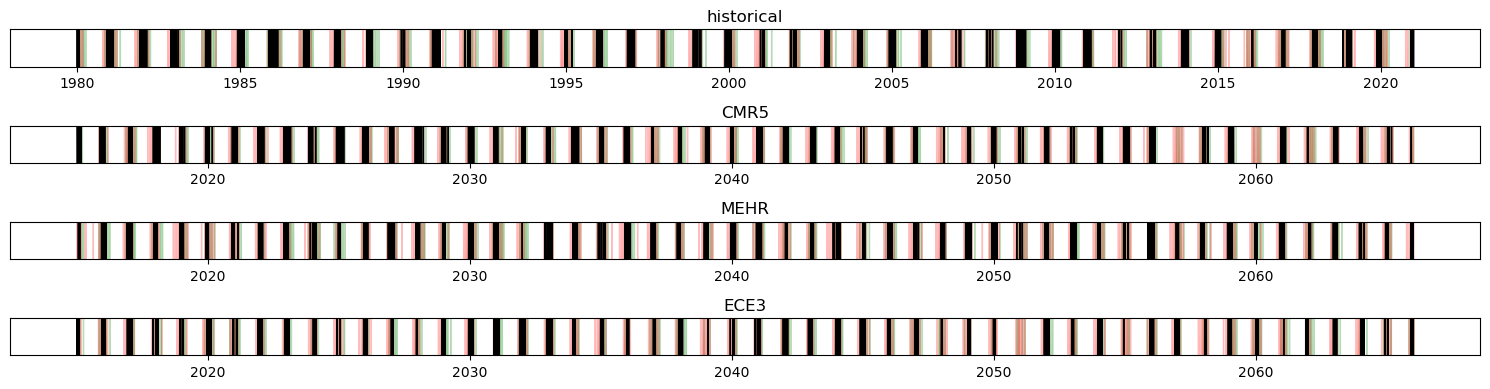

In [11]:
# Plot
palette = {"historical":"k", **{a: sns.color_palette("colorblind")[i] for i, a in enumerate(names) if a != "historical"}}
## Plot individual events
fig, axs = plt.subplots(len(climate_days), figsize = [15,4])
for i, a in enumerate(climate_days):
    event_stripplot(climate_days[a], axs[i], a, 'green', fill_between_kws = dict(alpha = 0.25))
    event_stripplot(energy_days[a], axs[i], a, 'red', fill_between_kws = dict(alpha = 0.25))
    event_stripplot(compound_days[a], axs[i], a, 'k')
fig.tight_layout()

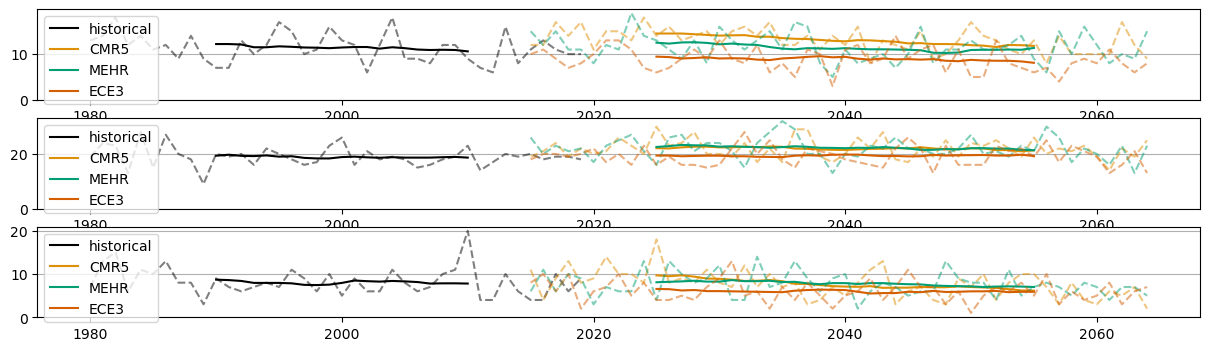

In [12]:
fig, axs = plt.subplots(3, figsize = [15, 4])
for i, d in enumerate([climate_events, energy_events, compound_events]):
    for j, a in enumerate(climate_events):
        N_events_per_year = pd.Series([e[0].year for e in d[a]]).value_counts().sort_index()
        N_events_per_year = pd.DataFrame(index = np.arange(*period_min_max[a])).join(N_events_per_year).fillna(0)
        N_events_per_year.plot(ax = axs[i], color = palette[a], linestyle = '--', alpha = 0.5, legend = False)
        N_events_per_year.rolling(20, center = True).mean().rename(columns={"count":a}).plot(ax = axs[i], color = palette[a], label = a)# legend = False,)
    axs[i].grid(axis = "y")
    axs[i].set_ylim(0)

Text(0.5, 1.0, 'Compound events')

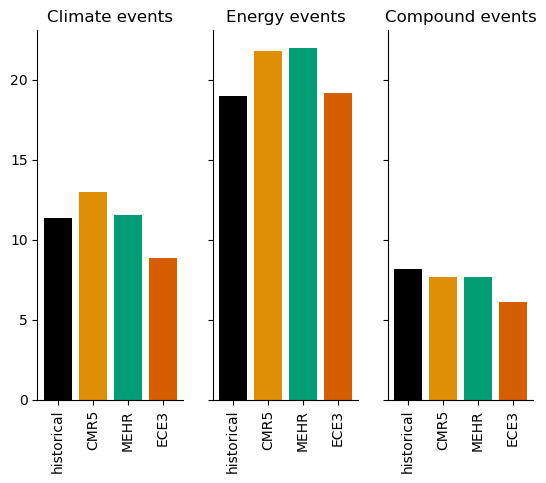

In [13]:
fig, axs = plt.subplots(1, 3, sharey = True)
nb_events_barplot(climate_events, period_len, axs[0], palette)
axs[0].set_title("Climate events")
nb_events_barplot(energy_events, period_len, axs[1], palette)
axs[1].set_title("Energy events")
nb_events_barplot(compound_events, period_len, axs[2], palette)
axs[2].set_title("Compound events")

(0.0, 15.0)

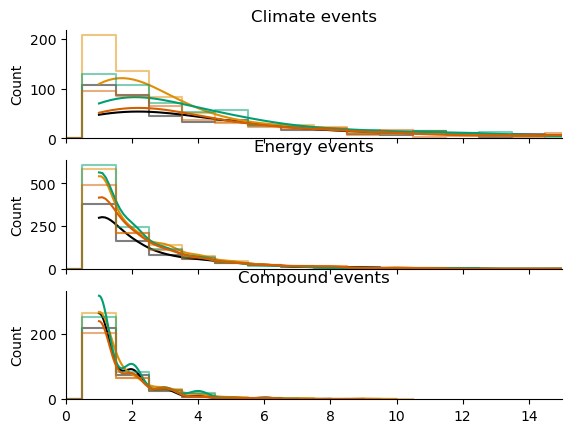

In [14]:
fig, axs = plt.subplots(3, sharex = True)
event_duration_histplot(climate_events, axs[0], palette, legend = False)
axs[0].set_title("Climate events")
event_duration_histplot(energy_events, axs[1], palette, legend = False)
axs[1].set_title("Energy events")
event_duration_histplot(compound_events, axs[2], palette, legend = False)
axs[2].set_title("Compound events")
axs[2].set_xlim(0,15)

Text(0.5, 1.0, 'Compound events')

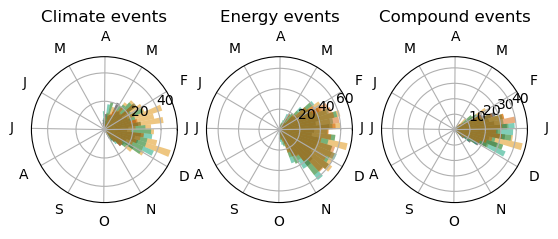

In [15]:
fig, axs = plt.subplots(1, 3, subplot_kw = dict(projection = "polar"))
event_seasonnality_histplot(climate_events, axs[0], palette, legend = False)
axs[0].set_title("Climate events")
event_seasonnality_histplot(energy_events, axs[1], palette, legend = False)
axs[1].set_title("Energy events")
event_seasonnality_histplot(compound_events, axs[2], palette, legend = False)
axs[2].set_title("Compound events")